In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
class ImageEnhancer:
    """Class for enhancing wildfire images to improve model performance"""
    
    @staticmethod
    def adjust_contrast(image, alpha=1.5):
        """Enhance contrast of the image"""
        return np.clip(alpha * image, 0, 1)
    
    @staticmethod
    def adjust_brightness(image, beta=0.1):
        """Adjust brightness of the image"""
        return np.clip(image + beta, 0, 1)
    
    @staticmethod
    def apply_clahe(image):
        """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
        img_yuv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_rgb / 255.0
    
    @staticmethod
    def sharpen_image(image):
        """Apply sharpening filter to image"""
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(image, -1, kernel)
        return np.clip(sharpened, 0, 1)
    
    @staticmethod
    def enhance_fire_colors(image):
        """Enhance red/orange colors typical in wildfire images"""
        # Convert to HSV and amplify red/orange hues
        hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        # Amplify reds and oranges (hue values near 0)
        red_mask = (hsv[:, :, 0] < 30) | (hsv[:, :, 0] > 150)
        hsv[:, :, 1] = np.where(red_mask, np.minimum(hsv[:, :, 1] * 1.5, 255), hsv[:, :, 1])
        enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return enhanced / 255.0
    
    @staticmethod
    def apply_all_enhancements(image):
        """Apply all enhancement techniques"""
        enhanced = ImageEnhancer.adjust_contrast(image)
        enhanced = ImageEnhancer.sharpen_image(enhanced)
        enhanced = ImageEnhancer.enhance_fire_colors(enhanced)
        return enhanced

In [3]:
class WildfireAutoencoder:
    def __init__(self, img_size=64, latent_dim=32):
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.classifier = None
        self.class_names = ['nofire', 'fire']
        
        # Data attributes
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.class_weights = None
        self.class_weight_dict = None

    def load_and_preprocess_data(self, train_dir, valid_dir, test_dir):
        """Load and preprocess image data from directories"""
        print("Loading and preprocessing data...")
        
        # Load training data
        self.x_train, self.y_train = self._load_images_from_dir(train_dir)
        # Load validation data
        self.x_val, self.y_val = self._load_images_from_dir(valid_dir)
        # Load test data
        self.x_test, self.y_test = self._load_images_from_dir(test_dir)
        
        # Calculate class weights
        self._calculate_class_weights()
        
        print(f"Training data shape: {self.x_train.shape}")
        print(f"Validation data shape: {self.x_val.shape}")
        print(f"Test data shape: {self.x_test.shape}")
        print(f"Class weights: {self.class_weight_dict}")

    def _load_images_from_dir(self, directory):
        """Load images from a directory and preprocess them"""
        images = []
        labels = []
        
        for class_name in self.class_names:
            class_dir = os.path.join(directory, class_name)
            class_idx = self.class_names.index(class_name)
            
            # Check if the directory exists before trying to process images
            if not os.path.exists(class_dir):
                print(f"Warning: Directory {class_dir} does not exist. Skipping.")
                continue
                
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Load and resize image
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Could not read image: {img_path}")
                        continue
                        
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
                    
                    images.append(img)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
        
        # Check if any images were loaded
        if not images:
            raise ValueError(f"No valid images found in directory: {directory}")
            
        # Shuffle data
        indices = np.arange(len(images))
        np.random.shuffle(indices)
        
        return np.array(images)[indices], np.array(labels)[indices]

    def _calculate_class_weights(self):
        """Calculate class weights for imbalanced datasets"""
        self.class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weight_dict = {i: weight for i, weight in enumerate(self.class_weights)}

    def load_processed_data(self, directory):
        """Load preprocessed data from disk"""
        print(f"Loading preprocessed data from {directory}...")
        self.x_train = np.load(os.path.join(directory, 'x_train.npy'))
        self.y_train = np.load(os.path.join(directory, 'y_train.npy'))
        self.x_val = np.load(os.path.join(directory, 'x_val.npy'))
        self.y_val = np.load(os.path.join(directory, 'y_val.npy'))
        self.x_test = np.load(os.path.join(directory, 'x_test.npy'))
        self.y_test = np.load(os.path.join(directory, 'y_test.npy'))
        
        # Calculate class weights
        self._calculate_class_weights()
        
        print(f"Data loaded successfully. Shapes: Train={self.x_train.shape}, Val={self.x_val.shape}, Test={self.x_test.shape}")

    def build_autoencoder(self):
        """Build the autoencoder model"""
        input_img = Input(shape=(self.img_size, self.img_size, 3))
        
        # Encoder
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        
        # Calculate shape before flatten
        shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
        
        # Latent space
        x = Flatten()(x)
        encoded = Dense(self.latent_dim, activation='relu')(x)
        
        # Create encoder model
        self.encoder = Model(input_img, encoded, name='encoder')
        
        # Decoder
        latent_input = Input(shape=(self.latent_dim,))
        x = Dense(np.prod(shape_before_flatten), activation='relu')(latent_input)
        x = Reshape(shape_before_flatten)(x)
        
        # Decoder path
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        
        # Create decoder model
        self.decoder = Model(latent_input, decoded, name='decoder')
        
        # Create autoencoder
        self.autoencoder = Model(input_img, self.decoder(self.encoder(input_img)), name='autoencoder')
        self.autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        print("Autoencoder built successfully.")
        print(self.encoder.summary())
        print(self.decoder.summary())

    def build_classifier(self):
        """Build the classifier model using the encoder"""
        if self.encoder is None:
            raise ValueError("Encoder must be built first. Call build_autoencoder() before build_classifier().")
        
        # Create classifier
        input_img = Input(shape=(self.img_size, self.img_size, 3))
        encoded = self.encoder(input_img)
        x = Dense(64, activation='relu')(encoded)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)
        
        self.classifier = Model(input_img, output, name='classifier')
        self.classifier.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        print("Classifier built successfully.")
        print(self.classifier.summary())

    def train_autoencoder(self, epochs=30, batch_size=32):
        """Train the autoencoder"""
        if self.autoencoder is None:
            raise ValueError("Autoencoder not built. Call build_autoencoder() first.")
            
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ModelCheckpoint('autoencoder_best.h5', save_best_only=True)
        ]
        
        print("Training autoencoder...")
        history = self.autoencoder.fit(
            self.x_train, self.x_train,
            validation_data=(self.x_val, self.x_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        
        return history

    def train_classifier(self, epochs=30, batch_size=32):
        """Train the classifier"""
        if self.classifier is None:
            raise ValueError("Classifier not built. Call build_classifier() first.")
            
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ModelCheckpoint('classifier_best.h5', save_best_only=True)
        ]
        
        print("Training classifier...")
        history = self.classifier.fit(
            self.x_train, self.y_train,
            validation_data=(self.x_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=self.class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Classifier Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Classifier Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return history

    def evaluate_classifier(self):
        """Evaluate the classifier on test data"""
        if self.classifier is None:
            raise ValueError("Classifier not built. Call build_classifier() first.")
            
        print("Evaluating classifier on test set...")
        loss, accuracy = self.classifier.evaluate(self.x_test, self.y_test, verbose=0)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Loss: {loss:.4f}")
        
        # Get predictions
        y_pred = self.classifier.predict(self.x_test)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # Display confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Display classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred_classes))
        
        return accuracy

    def save_models(self, directory):
        """Save all models to directory"""
        os.makedirs(directory, exist_ok=True)
        self.encoder.save(os.path.join(directory, 'encoder.h5'))
        self.decoder.save(os.path.join(directory, 'decoder.h5'))
        self.autoencoder.save(os.path.join(directory, 'autoencoder.h5'))
        self.classifier.save(os.path.join(directory, 'classifier.h5'))
        print(f"Models saved to {directory}")

    def load_models(self, directory):
        """Load models from directory"""
        self.encoder = load_model(os.path.join(directory, 'encoder.h5'))
        self.decoder = load_model(os.path.join(directory, 'decoder.h5'))
        self.autoencoder = load_model(os.path.join(directory, 'autoencoder.h5'))
        self.classifier = load_model(os.path.join(directory, 'classifier.h5'))
        print(f"Models loaded from {directory}")

    def visualize_reconstructions(self, num_images=5):
        """Visualize original and reconstructed images"""
        indices = np.random.choice(len(self.x_test), num_images, replace=False)
        test_images = self.x_test[indices]
        reconstructions = self.autoencoder.predict(test_images)
        
        plt.figure(figsize=(10, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(test_images[i])
            plt.title("Original")
            plt.axis('off')
            
            # Reconstructed
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstructions[i])
            plt.title("Reconstructed")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    def build_ensemble(self, num_models=3):
        """Build multiple classifier models for ensembling"""
        if self.encoder is None:
            raise ValueError("Encoder must be built first. Call build_autoencoder() before build_ensemble().")
        
        self.ensemble_models = []
        
        print(f"Building ensemble of {num_models} classifiers...")
        for i in range(num_models):
            # Create classifier with slightly different architecture
            input_img = Input(shape=(self.img_size, self.img_size, 3))
            encoded = self.encoder(input_img)
            
            # Vary the architecture slightly for each ensemble member
            x = Dense(64 + i*16, activation='relu')(encoded)
            x = Dropout(0.4 + i*0.1)(x)  # Different dropout rates
            output = Dense(1, activation='sigmoid')(x)
            
            model = Model(input_img, output, name=f'classifier_{i}')
            model.compile(
                optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            self.ensemble_models.append(model)
            print(f"Built ensemble model {i+1}/{num_models}")
        
        print("Ensemble built successfully.")

    def train_ensemble(self, epochs=30, batch_size=32):
        """Train all models in the ensemble"""
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        histories = []
        import time
        timestamp = int(time.time())  # Add a timestamp to make filenames unique
        
        for i, model in enumerate(self.ensemble_models):
            print(f"Training ensemble model {i+1}/{len(self.ensemble_models)}...")
            
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                ModelCheckpoint(f'ensemble_model_{i}_{timestamp}_best.h5', save_best_only=True)
            ]
            
            history = model.fit(
                self.x_train, self.y_train,
                validation_data=(self.x_val, self.y_val),
                epochs=epochs,
                batch_size=batch_size,
                class_weight=self.class_weight_dict,
                callbacks=callbacks,
                verbose=1
            )
            
            histories.append(history)
        
        return histories

    def ensemble_predict(self, x, method='voting'):
        """Make predictions using the ensemble
        
        Parameters:
        -----------
        x : array
            Input images to predict on
        method : str
            Ensembling method: 'voting', 'averaging', or 'weighted'
        
        Returns:
        --------
        predictions : array
            Ensemble predictions
        """
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        all_predictions = []
        
        # Get predictions from all models
        for model in self.ensemble_models:
            preds = model.predict(x)
            all_predictions.append(preds)
        
        all_predictions = np.array(all_predictions)
        
        # Apply ensembling method
        if method == 'voting':
            # Hard voting (majority)
            binary_preds = (all_predictions > 0.5).astype(int)
            ensemble_preds = np.mean(binary_preds, axis=0) > 0.5
            return ensemble_preds.astype(float)
        
        elif method == 'averaging':
            # Soft voting (average probabilities)
            return np.mean(all_predictions, axis=0)
        
        elif method == 'weighted':
            # Use validation accuracy as weights
            weights = []
            for model in self.ensemble_models:
                _, val_acc = model.evaluate(self.x_val, self.y_val, verbose=0)
                weights.append(val_acc)
            
            # Normalize weights
            weights = np.array(weights) / np.sum(weights)
            
            # Apply weights to predictions
            weighted_preds = np.zeros_like(all_predictions[0])
            for i, preds in enumerate(all_predictions):
                weighted_preds += weights[i] * preds
            
            return weighted_preds
        
        else:
            raise ValueError("Method must be 'voting', 'averaging', or 'weighted'")

    def evaluate_ensemble(self, method='averaging'):
        """Evaluate the ensemble on test data"""
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        print(f"Evaluating ensemble using {method} method...")
        
        # Get ensemble predictions
        y_pred = self.ensemble_predict(self.x_test, method=method)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # Calculate accuracy
        accuracy = accuracy_score(self.y_test, y_pred_classes)
        print(f"Ensemble Test Accuracy: {accuracy:.4f}")
        
        # Display confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Ensemble Confusion Matrix ({method})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Display classification report
        print("\nEnsemble Classification Report:")
        print(classification_report(self.y_test, y_pred_classes))
        
        return accuracy

    def save_ensemble(self, directory):
        """Save all ensemble models to directory"""
        if not hasattr(self, 'ensemble_models') or not self.ensemble_models:
            raise ValueError("Ensemble not built. Call build_ensemble() first.")
        
        ensemble_dir = os.path.join(directory, 'ensemble')
        os.makedirs(ensemble_dir, exist_ok=True)
        
        for i, model in enumerate(self.ensemble_models):
            model.save(os.path.join(ensemble_dir, f'ensemble_model_{i}.h5'))
        
        print(f"Ensemble models saved to {ensemble_dir}")

    def load_ensemble(self, directory, num_models):
        """Load ensemble models from directory"""
        ensemble_dir = os.path.join(directory, 'ensemble')
        self.ensemble_models = []
        
        for i in range(num_models):
            model_path = os.path.join(ensemble_dir, f'ensemble_model_{i}.h5')
            if os.path.exists(model_path):
                self.ensemble_models.append(load_model(model_path))
        
        print(f"Loaded {len(self.ensemble_models)} ensemble models from {ensemble_dir}")
    
    def compare_all_models(self):
        """Compare accuracy and performance metrics for base classifier and all ensemble methods"""
        print("=" * 50)
        print("MODEL PERFORMANCE COMPARISON")
        print("=" * 50)
        
        results = {}
        
        # 1. Base classifier
        if self.classifier is not None:
            print("\nEvaluating base classifier...")
            loss, base_acc = self.classifier.evaluate(self.x_test, self.y_test, verbose=0)
            print(f"Base classifier accuracy: {base_acc:.4f}")
            
            # Get predictions and metrics
            y_pred = self.classifier.predict(self.x_test)
            y_pred_classes = (y_pred > 0.5).astype(int)
            
            precision = precision_score(self.y_test, y_pred_classes)
            recall = recall_score(self.y_test, y_pred_classes)
            f1 = f1_score(self.y_test, y_pred_classes)
            
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            
            results['Base Classifier'] = {
                'accuracy': base_acc,
                'precision': precision,
                'recall': recall,
                'f1': f1
            }
        
        # 2. Individual ensemble models
        if hasattr(self, 'ensemble_models') and self.ensemble_models:
            print("\nEvaluating individual ensemble models...")
            for i, model in enumerate(self.ensemble_models):
                loss, acc = model.evaluate(self.x_test, self.y_test, verbose=0)
                print(f"Ensemble model {i+1}: Accuracy = {acc:.4f}")
                
                # Get predictions and metrics
                y_pred = model.predict(self.x_test)
                y_pred_classes = (y_pred > 0.5).astype(int)
                
                precision = precision_score(self.y_test, y_pred_classes)
                recall = recall_score(self.y_test, y_pred_classes)
                f1 = f1_score(self.y_test, y_pred_classes)
                
                results[f'Ensemble Model {i+1}'] = {
                    'accuracy': acc,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                }
        
        # 3. Combined ensemble methods
        if hasattr(self, 'ensemble_models') and self.ensemble_models:
            print("\nEvaluating ensemble methods...")
            ensemble_methods = ['voting', 'averaging', 'weighted']
            
            for method in ensemble_methods:
                print(f"\nMethod: {method.capitalize()}")
                y_pred = self.ensemble_predict(self.x_test, method=method)
                y_pred_classes = (y_pred > 0.5).astype(int)
                
                # Calculate metrics
                acc = accuracy_score(self.y_test, y_pred_classes)
                precision = precision_score(self.y_test, y_pred_classes)
                recall = recall_score(self.y_test, y_pred_classes)
                f1 = f1_score(self.y_test, y_pred_classes)
                
                print(f"Accuracy: {acc:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print(f"F1 Score: {f1:.4f}")
                
                results[f'Ensemble ({method})'] = {
                    'accuracy': acc,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                }
        
        # 4. Create summary table
        print("\n" + "=" * 50)
        print("SUMMARY TABLE")
        print("=" * 50)
        print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
        print("-" * 65)
        
        for model_name, metrics in results.items():
            print(f"{model_name:<25} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
                f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")
        
        # 5. Visualize results
        plt.figure(figsize=(12, 8))
        
        # Plot accuracy comparison
        plt.subplot(2, 2, 1)
        models = list(results.keys())
        accuracies = [results[model]['accuracy'] for model in models]
        plt.bar(models, accuracies)
        plt.title('Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Plot precision comparison
        plt.subplot(2, 2, 2)
        precisions = [results[model]['precision'] for model in models]
        plt.bar(models, precisions)
        plt.title('Precision Comparison')
        plt.ylabel('Precision')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Plot recall comparison
        plt.subplot(2, 2, 3)
        recalls = [results[model]['recall'] for model in models]
        plt.bar(models, recalls)
        plt.title('Recall Comparison')
        plt.ylabel('Recall')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Plot F1 comparison
        plt.subplot(2, 2, 4)
        f1s = [results[model]['f1'] for model in models]
        plt.bar(models, f1s)
        plt.title('F1 Score Comparison')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.show()
        
        return results

In [4]:
# Define data paths (replace with your actual paths)
data_root = "wildfire"  # Replace with your dataset path
train_dir = r"C:\Users\shash\Downloads\wildfire\FlameVision  A new dataset for wildfire classification and detection using aerial imagery\FlameVision\Classification\train"
valid_dir = r"C:\Users\shash\Downloads\wildfire\FlameVision  A new dataset for wildfire classification and detection using aerial imagery\FlameVision\Classification\valid"
test_dir =  r"C:\Users\shash\Downloads\wildfire\FlameVision  A new dataset for wildfire classification and detection using aerial imagery\FlameVision\Classification\test"

# Create model instance
model = WildfireAutoencoder(img_size=64, latent_dim=32)
print("WildfireAutoencoder model initialized")

WildfireAutoencoder model initialized


Loading and preprocessing data...
Training data shape: (6800, 64, 64, 3)
Validation data shape: (900, 64, 64, 3)
Test data shape: (900, 64, 64, 3)
Class weights: {0: np.float64(1.0625), 1: np.float64(0.9444444444444444)}


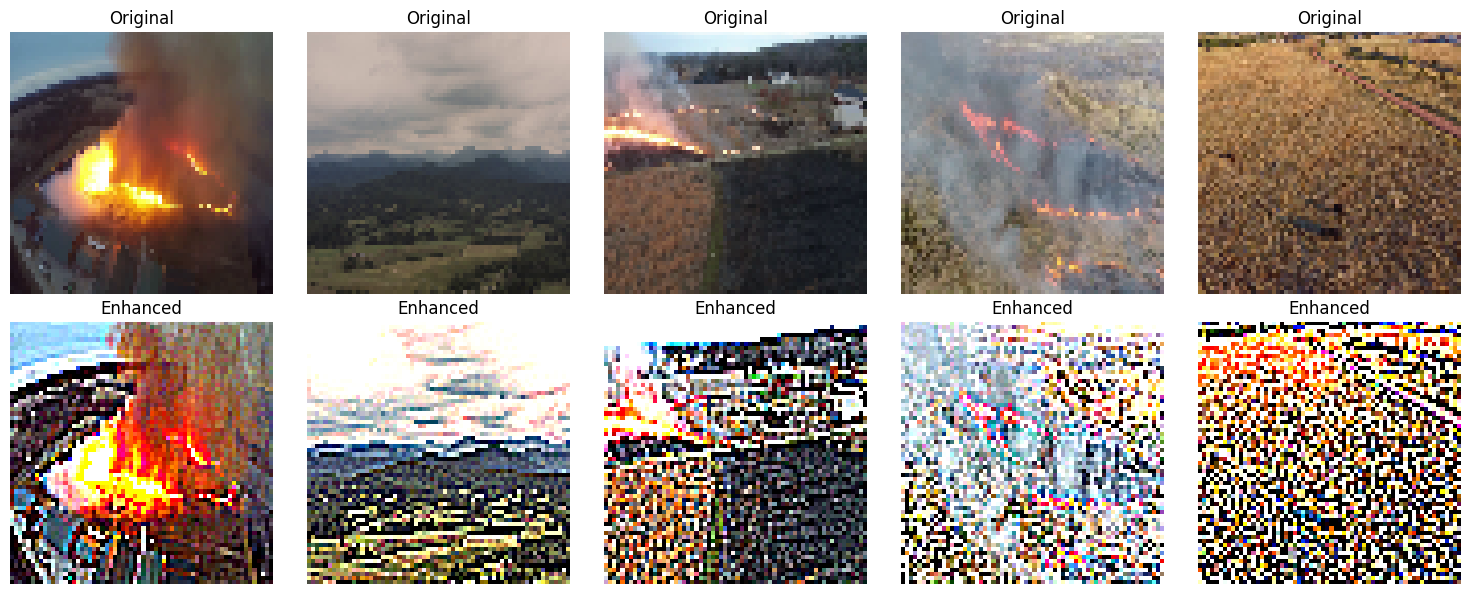

In [5]:
# Either load raw data and preprocess
model.load_and_preprocess_data(train_dir, valid_dir, test_dir)

# OR load already preprocessed data (comment one of these sections)
# preprocessed_data_dir = "preprocessed_data"
# model.load_processed_data(preprocessed_data_dir)

# Apply image enhancement to training data (optional)
enhanced_x_train = np.array([ImageEnhancer.apply_all_enhancements(img) for img in model.x_train])

# Display a few original and enhanced images to compare
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    idx = np.random.randint(0, len(model.x_train))
    axes[0, i].imshow(model.x_train[idx])
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(enhanced_x_train[idx])
    axes[1, i].set_title("Enhanced")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Optional: Replace original training data with enhanced data
# model.x_train = enhanced_x_train

In [6]:
# Cell 3: Build the autoencoder model
autoencoder = model.build_autoencoder()
print(f"Autoencoder architecture created with latent dimension: {model.latent_dim}")
print("Encoder summary:")
model.encoder.summary()
print("\nDecoder summary:")
model.decoder.summary()

Autoencoder built successfully.


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,424 (732.12 KB)

 Trainable params: 187,424 (732.12 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,355 (892.01 KB)

 Trainable params: 228,355 (892.01 KB)

 Non-trainable params: 0 (0.00 B)

None
Autoencoder architecture created with latent dimension: 32
Encoder summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,424 (732.12 KB)

 Trainable params: 187,424 (732.12 KB)

 Non-trainable params: 0 (0.00 B)


Decoder summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,355 (892.01 KB)

 Trainable params: 228,355 (892.01 KB)

 Non-trainable params: 0 (0.00 B)

Training autoencoder...
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0311

213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.0310 - val_loss: 0.0103
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0121

213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 0.0121 - val_loss: 0.0088
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0099

213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 10/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - loss: 0.0069 - val_loss: 0.0081


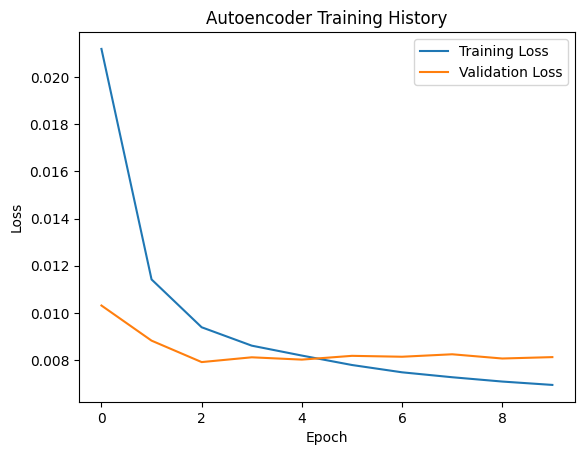

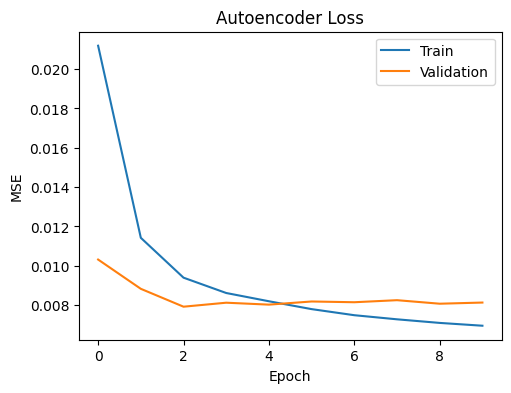

In [7]:
# Train the autoencoder
autoencoder_history = model.train_autoencoder(epochs=30, batch_size=32)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(autoencoder_history.history['loss'])
plt.plot(autoencoder_history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Classifier built successfully.


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       187,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,601 (740.63 KB)

 Trainable params: 189,601 (740.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Training classifier...
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5783 - loss: 0.7342

213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.5786 - loss: 0.7338 - val_accuracy: 0.9778 - val_loss: 0.2979
Epoch 2/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8249 - loss: 0.4206

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8251 - loss: 0.4202 - val_accuracy: 0.9444 - val_loss: 0.2672
Epoch 3/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8764 - loss: 0.3036

213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.8765 - loss: 0.3033 - val_accuracy: 0.9744 - val_loss: 0.1796
Epoch 4/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9215 - loss: 0.2138

213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9215 - loss: 0.2137 - val_accuracy: 0.9956 - val_loss: 0.0981
Epoch 5/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9403 - loss: 0.1738

213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.9404 - loss: 0.1737 - val_accuracy: 0.9944 - val_loss: 0.0850
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9623 - loss: 0.1307 - val_accuracy: 0.9711 - val_loss: 0.1016
Epoch 7/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9673 - loss: 0.1148

213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.9673 - loss: 0.1147 - val_accuracy: 0.9911 - val_loss: 0.0553
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9749 - loss: 0.0867 - val_accuracy: 0.9689 - val_loss: 0.1600
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9817 - loss: 0.0661

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9817 - loss: 0.0661 - val_accuracy: 0.9833 - val_loss: 0.0513
Epoch 10/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9809 - loss: 0.0612

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.9809 - loss: 0.0611 - val_accuracy: 0.9911 - val_loss: 0.0330
Epoch 11/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9861 - loss: 0.0469 - val_accuracy: 0.9467 - val_loss: 0.1661
Epoch 12/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.9913 - loss: 0.0369 - val_accuracy: 0.9789 - val_loss: 0.0940
Epoch 13/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9880 - loss: 0.0338 - val_accuracy: 0.9889 - val_loss: 0.0416
Epoch 14/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9925 - loss: 0.0324 - val_accuracy: 0.9822 - val_loss: 0.0665
Epoch 15/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.9905 - loss: 0.0330 - val_accuracy: 0.9900 - val_loss: 0.0367
Epoch 16/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9934 - loss: 0.0269 - val_accuracy: 0.9733 - val_loss: 0.0978
Epoch 17/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9945 - loss: 0.0198 - val_

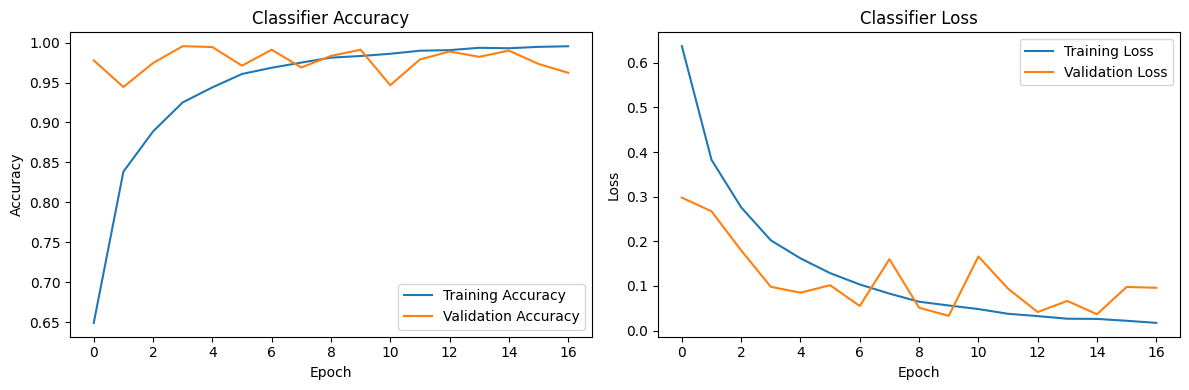

In [8]:
# Build the classifier 
model.build_classifier()

# Train the classifier
classifier_history = model.train_classifier(epochs=30, batch_size=32)

Evaluating classifier on test set...
Test Accuracy: 0.9822
Test Loss: 0.0440
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


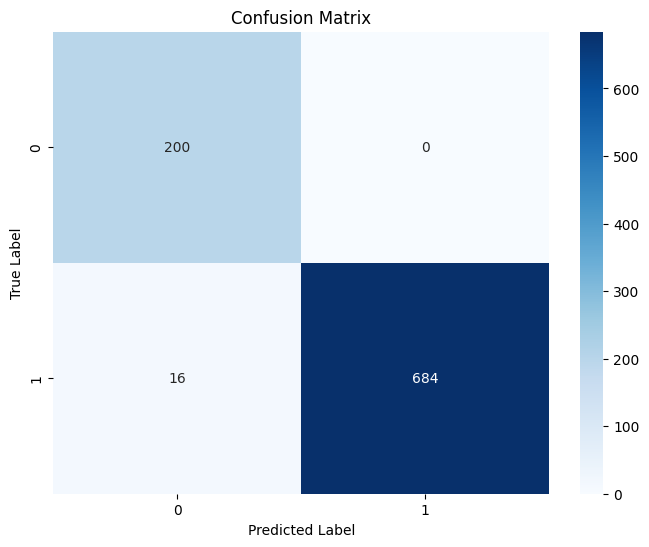


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       200
           1       1.00      0.98      0.99       700

    accuracy                           0.98       900
   macro avg       0.96      0.99      0.97       900
weighted avg       0.98      0.98      0.98       900

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


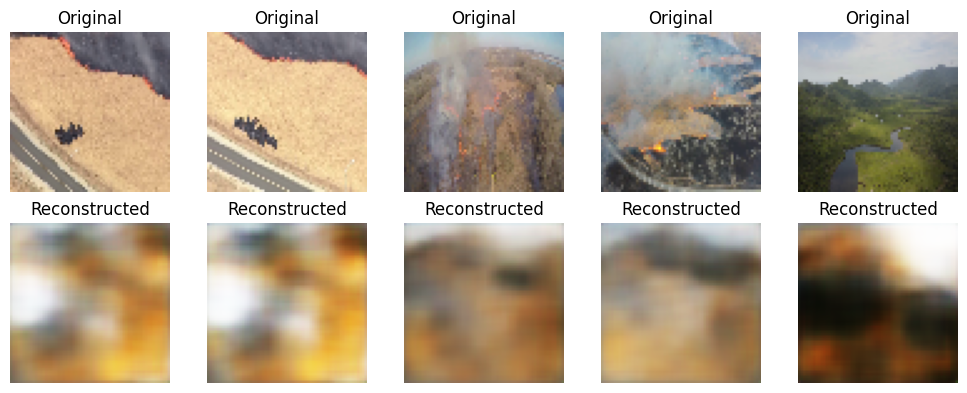

Models saved to wildfire_model


In [9]:
# Evaluate classifier on test data
model.evaluate_classifier()

# Visualize reconstructions
model.visualize_reconstructions(num_images=5)

# Save the trained models
model.save_models("wildfire_model")

In [10]:
from tensorflow.keras.models import load_model
import os

def load_models(model, directory):
    """Load models from directory into an instance"""
    model.encoder = load_model(os.path.join(directory, 'encoder.h5'), compile=False)
    model.decoder = load_model(os.path.join(directory, 'decoder.h5'), compile=False)
    model.autoencoder = load_model(os.path.join(directory, 'autoencoder.h5'), compile=False)
    model.classifier = load_model(os.path.join(directory, 'classifier.h5'), compile=False)
    print(f"Models loaded from {directory}")

load_models(model,'wildfire_model')


Models loaded from wildfire_model


In [11]:
# Build ensemble with your pre-trained encoder
model.build_ensemble(num_models=3)

# Train the ensemble
model.train_ensemble()

# Then save the ensemble to a specific folder
ensemble_folder = "wildfire_ensemble_model_drone"
model.save_ensemble(ensemble_folder)

Building ensemble of 3 classifiers...
Built ensemble model 1/3
Built ensemble model 2/3
Built ensemble model 3/3
Ensemble built successfully.
Training ensemble model 1/3...
Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8226 - loss: 0.3816

213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.8229 - loss: 0.3811 - val_accuracy: 0.9800 - val_loss: 0.1596
Epoch 2/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9618 - loss: 0.1387

213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.9618 - loss: 0.1385 - val_accuracy: 0.9967 - val_loss: 0.0527
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.9721 - loss: 0.0948 - val_accuracy: 0.9844 - val_loss: 0.1102
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9826 - loss: 0.0641 - val_accuracy: 0.9878 - val_loss: 0.0596
Epoch 5/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9844 - loss: 0.0521

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9844 - loss: 0.0521 - val_accuracy: 0.9978 - val_loss: 0.0252
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9893 - loss: 0.0420 - val_accuracy: 0.9989 - val_loss: 0.0279
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.9933 - loss: 0.0326 - val_accuracy: 0.9722 - val_loss: 0.1063
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.9929 - loss: 0.0272 - val_accuracy: 0.9978 - val_loss: 0.0269
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9943 - loss: 0.0198 - val_accuracy: 0.9956 - val_loss: 0.0329
Epoch 10/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9949 - loss: 0.0208 - val_accuracy: 0.9900 - val_loss: 0.0388
Training ensemble model 2/3...
Epoch 1/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7361 - loss: 0.5730

213/213 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.7371 - loss: 0.5710 - val_accuracy: 0.9789 - val_loss: 0.1324
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9504 - loss: 0.1670

213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9504 - loss: 0.1669 - val_accuracy: 0.9822 - val_loss: 0.0856
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9718 - loss: 0.0947 - val_accuracy: 0.9822 - val_loss: 0.0884
Epoch 4/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9747 - loss: 0.0788

213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9747 - loss: 0.0787 - val_accuracy: 0.9956 - val_loss: 0.0372
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9858 - loss: 0.0528 - val_accuracy: 0.9856 - val_loss: 0.0426
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9856 - loss: 0.0431 - val_accuracy: 0.9833 - val_loss: 0.0576
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9865 - loss: 0.0410 - val_accuracy: 0.9844 - val_loss: 0.0468
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9896 - loss: 0.0315

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.9896 - loss: 0.0315 - val_accuracy: 0.9956 - val_loss: 0.0185
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9917 - loss: 0.0270 - val_accuracy: 0.9811 - val_loss: 0.0731
Epoch 10/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9914 - loss: 0.0272 - val_accuracy: 0.9944 - val_loss: 0.0197
Epoch 11/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9944 - loss: 0.0203

213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9944 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 12/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - accuracy: 0.9945 - loss: 0.0177 - val_accuracy: 0.9956 - val_loss: 0.0184
Epoch 13/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9957 - loss: 0.0148

213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.9957 - loss: 0.0148 - val_accuracy: 0.9989 - val_loss: 0.0066
Epoch 14/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9966 - loss: 0.0125 - val_accuracy: 0.9956 - val_loss: 0.0244
Epoch 15/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9958 - loss: 0.0121 - val_accuracy: 0.9978 - val_loss: 0.0090
Epoch 16/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9977 - loss: 0.0101

213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9977 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 17/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9977 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 18/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9965 - loss: 0.0137

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9965 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 19/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.9975 - loss: 0.0107 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 20/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9994 - loss: 0.0066 - val_accuracy: 0.9989 - val_loss: 0.0102
Epoch 21/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.9997 - loss: 0.0054 - val_accuracy: 0.9933 - val_loss: 0.0317
Epoch 22/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accuracy: 0.9600 - val_loss: 0.0695
Epoch 23/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0053
Training ensemble model 3/3...
Epoch 1/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8407 - loss: 0.3819

213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8412 - loss: 0.3807 - val_accuracy: 0.9944 - val_loss: 0.0812
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9673 - loss: 0.0959

213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9673 - loss: 0.0958 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9895 - loss: 0.0426

213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9895 - loss: 0.0426 - val_accuracy: 1.0000 - val_loss: 0.0175
Epoch 4/30
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9887 - loss: 0.0305

213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9887 - loss: 0.0305 - val_accuracy: 0.9989 - val_loss: 0.0173
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.9940 - loss: 0.0222 - val_accuracy: 0.9922 - val_loss: 0.0262
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9955 - loss: 0.0171

213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9955 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9950 - loss: 0.0174 - val_accuracy: 0.9989 - val_loss: 0.0082
Epoch 8/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9956 - val_loss: 0.0150
Epoch 9/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9971 - loss: 0.0091 - val_accuracy: 0.9967 - val_loss: 0.0116
Epoch 10/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9982 - loss: 0.0081 - val_accuracy: 0.9922 - val_loss: 0.0227
Epoch 11/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9975 - loss: 0.0110 - val_accuracy: 0.9989 - val_loss: 0.0083


Ensemble models saved to wildfire_ensemble_model_drone\ensemble


In [12]:
# To load the models back
model.load_ensemble(ensemble_folder, num_models=3)

Loaded 3 ensemble models from wildfire_ensemble_model_drone\ensemble


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


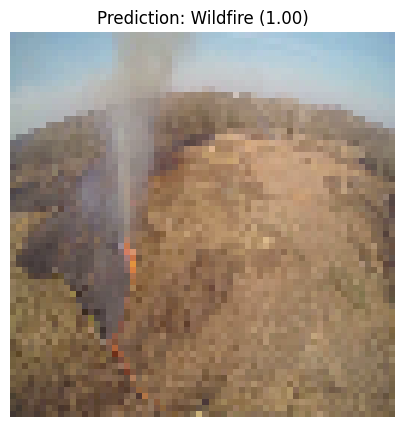

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


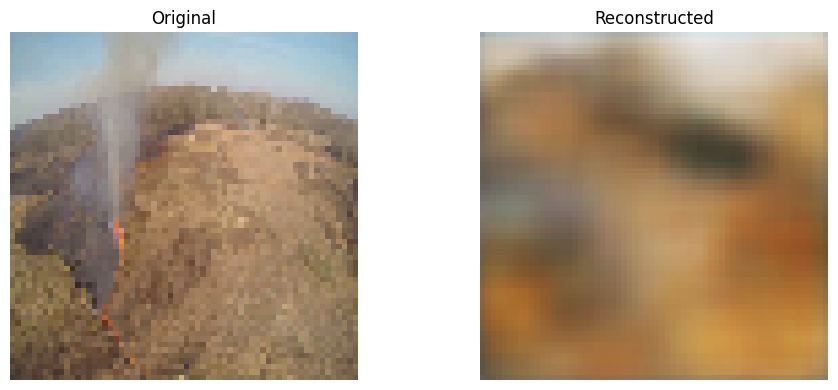

Wildfire probability: 0.9986


In [13]:
def predict_wildfire(model, image_path):
    """Make a prediction on a new image"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (model.img_size, model.img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    
    # Make prediction
    pred = model.classifier.predict(np.expand_dims(img, axis=0))[0][0]
    
    # Visualize image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Prediction: {'Wildfire' if pred > 0.5 else 'No Wildfire'} ({pred:.2f})")
    plt.axis('off')
    plt.show()
    
    # Get reconstruction
    reconst = model.autoencoder.predict(np.expand_dims(img, axis=0))[0]
    
    # Visualize original and reconstruction
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconst)
    plt.title("Reconstructed")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred

# Example usage
test_image_path = r"C:\Users\shash\Downloads\wildfire\FlameVision  A new dataset for wildfire classification and detection using aerial imagery\FlameVision\Classification\test\fire\fire (4220).png"
prediction = predict_wildfire(model, test_image_path)
print(f"Wildfire probability: {prediction:.4f}")